In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../src/")
import json

import numpy as np
import pandas as pd
import math
from scipy.stats import ttest_rel, ttest_ind
from datasets import Dataset, list_metrics, load_metric
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from results_analysis.analyze_exp_results import ExpAnalyzer
from results_analysis.analyze_personalized_exp_results import PerPopulationExpAnalyzer
from results_analysis.analysis_utils import plot_user_perf_by_sample_count

from runners.runner_utils import loss_to_perplexity

In [3]:
base_result_dir = "/data/ddmg/redditlanguagemodeling/results/"

In [4]:
def collect_result(result_dir, pretrained_perf_df=None, test_users=None):
    full_dir = os.path.join(base_result_dir, result_dir)
    ea = ExpAnalyzer(full_dir)
    if test_users is not None:
        ea.author_result_df = ea.author_result_df[ea.author_result_df["author"].isin(test_users)]
    print("Mean Perplexity Per Author: {}".format(ea.author_result_df.mean()["perplexity"]))
    print("Std Perplexity Per Author: {}".format(ea.author_result_df.std()["perplexity"]))
    if pretrained_perf_df is not None:
        merged_df = pretrained_perf_df.merge(ea.author_result_df, how="inner", on="author")
        merged_df["perplexity_diff"] = merged_df.apply(lambda x: x['perplexity_x'] - x['perplexity_y'], axis=1)
        print("Mean Perplexity Diff Per Author: {}".format(merged_df.mean()["perplexity_diff"]))
        print("Std Perplexity Diff Per Author: {}".format(merged_df.std()["perplexity_diff"]))
        return merged_df
    return ea

In [17]:
def collect_result_multi_seed(result_dir, init_seed=42, num_runs=10):
    author_results = []
    train_hists = []
    eval_results = []
    for i in range(num_runs):
        seed = init_seed + i
        full_dir = os.path.join(base_result_dir, result_dir, str(seed))
        ea = ExpAnalyzer(full_dir)
        ea.author_result_df["seed"] = seed
        ea.train_hist_df["seed"] = seed
        author_results.append(ea.author_result_df)
        train_hists.append(ea.train_hist_df)
    author_result_df = pd.concat(author_results)
    train_hist_df = pd.concat(train_hists)
    return author_result_df, train_hist_df

In [82]:
ea = collect_result("1_bert_distill_pretrained")
ea.author_result_df["seed"] = 42
ea.author_result_df["exp"] = "pretrained"

Mean Perplexity Per Author: 21.095752445689254
Std Perplexity Per Author: 11.11950021612392


In [18]:
ft_all_result_df, ft_all_train_hist_df = collect_result_multi_seed("debug/finetune_all_deterministic_test")

In [21]:
es_ft_all_result_df, es_ft_all_train_hist_df = collect_result_multi_seed("debug/finetune_all_deterministic_test_even_weight_sample")

In [65]:
ft_author_result_df, ft_author_train_hist_df = collect_result_multi_seed("debug/finetune_author_deterministic_test")

In [66]:
es_ft_author_result_df, es_ft_author_train_hist_df = collect_result_multi_seed("debug/finetune_author_deterministic_test_even_weights")

In [35]:
sw_5_result_df, sw_5_train_hist_df = collect_result_multi_seed("debug/sw_deterministic_test_5")

In [36]:
sw_9_result_df, sw_9_train_hist_df = collect_result_multi_seed("debug/sw_deterministic_test_9")

In [37]:
sw_1_result_df, sw_1_train_hist_df = collect_result_multi_seed("debug/sw_deterministic_test_1")

In [83]:
ft_all_result_df["exp"] = "finetune-all-og"
es_ft_all_result_df["exp"] = "finetune-all-es"
ft_author_result_df["exp"] = "finetune-author-og"
es_ft_author_result_df["exp"] = "finetune-author-es"
sw_5_result_df["exp"] = "sampleweight-.5"
sw_9_result_df["exp"] = "sampleweight-.9"
sw_1_result_df["exp"] = "sampleweight-1"
result_df = pd.concat([ft_all_result_df, es_ft_all_result_df,
                       sw_5_result_df, sw_9_result_df, sw_1_result_df, 
                       ft_author_result_df, es_ft_author_result_df,
                       ea.author_result_df])

In [68]:
ft_all_train_hist_df["exp"] = "finetune-all-og"
es_ft_all_train_hist_df["exp"] = "finetune-all-es"
ft_author_train_hist_df["exp"] = "finetune-author-og"
es_ft_author_train_hist_df["exp"] = "finetune-author-es"
sw_5_train_hist_df["exp"] = "sampleweight-.5"
sw_9_train_hist_df["exp"] = "sampleweight-.9"
sw_1_train_hist_df["exp"] = "sampleweight-1"
train_hist_df = pd.concat([ft_all_train_hist_df, es_ft_all_train_hist_df,
                           sw_5_train_hist_df, sw_9_train_hist_df, sw_1_train_hist_df,
                           ft_author_train_hist_df, es_ft_author_train_hist_df,
                            ])

In [49]:
train_hist_df

,step,data,loss,perplexity,seed,exp
0,5.0,train,2.627200,13.834978,42,finetune-all-og
1,10.0,train,2.033500,7.640782,42,finetune-all-og
2,5.0,val,2.606242,13.548044,42,finetune-all-og
3,10.0,val,2.600247,13.467063,42,finetune-all-og
0,5.0,train,2.602700,13.500139,43,finetune-all-og
...,...,...,...,...,...,...
3,10.0,val,2.705217,14.957557,50,sampleweight-1
0,5.0,train,0.805600,2.238039,51,sampleweight-1
1,10.0,train,0.610700,1.841720,51,sampleweight-1
2,5.0,val,2.679187,14.573238,51,sampleweight-1


### Problem - I've just been running on the first 100 examples and the target author I've been using doesn't have data in these examples

In [70]:
train_hist_df["exp"].unique()

array(['finetune-all-og', 'finetune-all-es', 'sampleweight-.5',
       'sampleweight-.9', 'sampleweight-1', 'finetune-author-og',
       'finetune-author-es'], dtype=object)

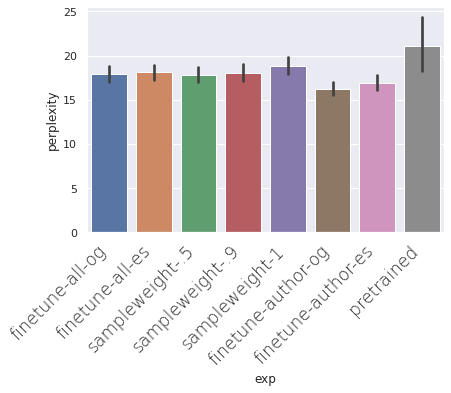

In [84]:
sns.barplot(data=result_df, x="exp", y="perplexity")
plt.tight_layout()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

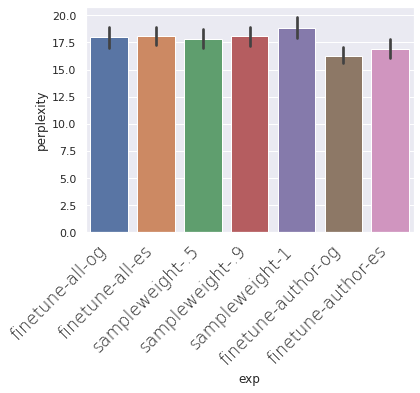

In [59]:
sns.barplot(data=result_df, x="exp", y="perplexity")
plt.tight_layout()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [52]:
train_hist_df["exp"].unique()

array(['finetune-all-og', 'finetune-all-es', 'sampleweight-.5',
       'sampleweight-.9', 'sampleweight-1'], dtype=object)

In [63]:
train_hist_df.groupby(["exp", "data", "step"]).mean()["perplexity"]

exp              data   step
finetune-all-es  train  5.0     12.862561
                        10.0     7.468539
                 val    5.0     14.010669
                        10.0    13.536185
finetune-all-og  train  5.0     13.752332
                        10.0     7.747966
                 val    5.0     13.688586
                        10.0    13.442495
sampleweight-.5  train  5.0     12.869952
                        10.0     5.330686
                 val    5.0     14.044510
                        10.0    13.503235
sampleweight-.9  train  5.0      2.615459
                        10.0     2.013266
                 val    5.0     14.235541
                        10.0    13.875500
sampleweight-1   train  5.0      2.216601
                        10.0     1.815523
                 val    5.0     14.629366
                        10.0    15.096624
Name: perplexity, dtype: float64

In [64]:
train_hist_df.groupby(["exp", "data", "step"]).std()["perplexity"]

exp              data   step
finetune-all-es  train  5.0     0.202645
                        10.0    0.116526
                 val    5.0     0.119216
                        10.0    0.119015
finetune-all-og  train  5.0     0.193027
                        10.0    0.109603
                 val    5.0     0.074907
                        10.0    0.059544
sampleweight-.5  train  5.0     0.254374
                        10.0    0.079430
                 val    5.0     0.066921
                        10.0    0.055116
sampleweight-.9  train  5.0     0.017211
                        10.0    0.018513
                 val    5.0     0.084444
                        10.0    0.042956
sampleweight-1   train  5.0     0.024513
                        10.0    0.026073
                 val    5.0     0.147338
                        10.0    0.181543
Name: perplexity, dtype: float64

[(1.0, 37.0)]

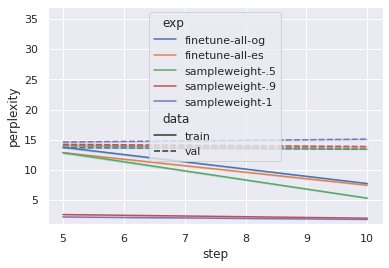

In [76]:
keep_set = ["finetune-all-og", "finetune-all-es", "sampleweight-.5", "sampleweight-.9", "sampleweight-1"]
ax = sns.lineplot(data=train_hist_df[train_hist_df["exp"].isin(keep_set)], x="step", y="perplexity", hue="exp", style="data")
ax.set(ylim=(1, 37))

<AxesSubplot:xlabel='step', ylabel='perplexity'>

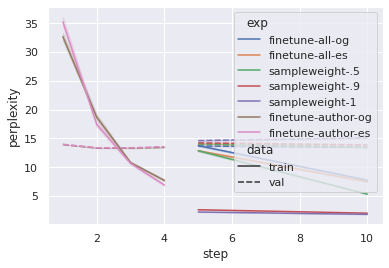

In [71]:
sns.lineplot(data=train_hist_df, x="step", y="perplexity", hue="exp", style="data")

[(1.0, 37.0)]

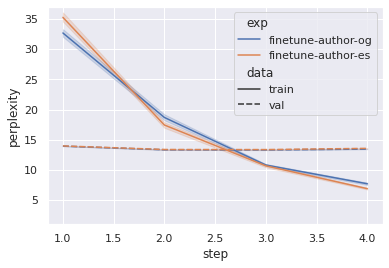

In [78]:
ax = sns.lineplot(data=train_hist_df[train_hist_df["exp"].isin(["finetune-author-og", "finetune-author-es"])], 
             x="step", y="perplexity", hue="exp", style="data")
ax.set(ylim=(1, 37))

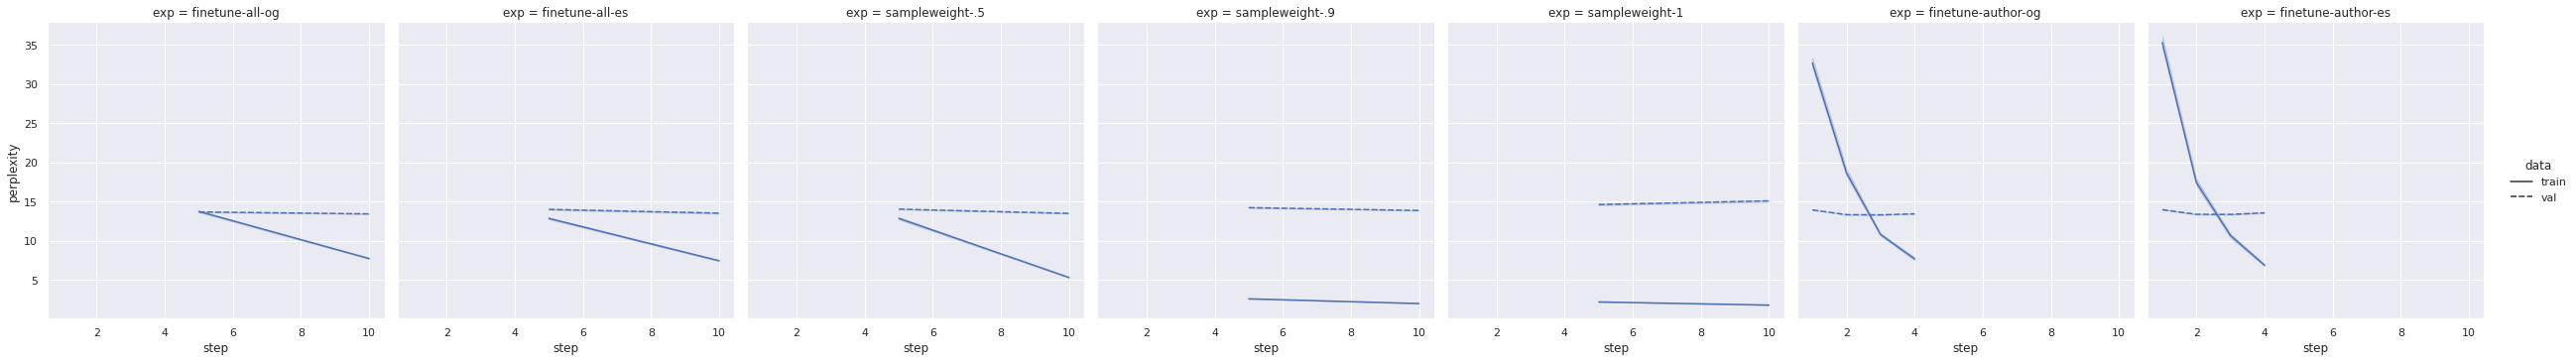

In [74]:
sns.relplot(data=train_hist_df, x="step", y="perplexity", style="data", col="exp", kind="line")